In [55]:
import os
from copy import deepcopy
import numpy as np
import pandas as pd
from difflib import SequenceMatcher
from pathlib import Path

from sklearn.model_selection import train_test_split

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", 
              style="white")

from datasets import Dataset
import evaluate
from transformers import (BartTokenizer,
                          BartForConditionalGeneration,
                          DataCollatorForSeq2Seq,
                          EarlyStoppingCallback,
                          Seq2SeqTrainingArguments,
                          Seq2SeqTrainer, 
                          get_scheduler)
import torch
import bitsandbytes as bnb

In [56]:
# https://www.kaggle.com/datasets/asaniczka/data-scientist-linkedin-job-postings
import kagglehub
# Download latest version
path = kagglehub.dataset_download("asaniczka/data-scientist-linkedin-job-postings")

print("Path to dataset files:", path)
files = os.listdir(path)
# Print the names of the files
for file in files:
    print(file)

Path to dataset files: /Users/oliverzhou/.cache/kagglehub/datasets/asaniczka/data-scientist-linkedin-job-postings/versions/103
postings.csv


In [57]:
postings = pd.read_csv(path+'/postings.csv')
postings.head()

,job_title,company,job_location,job_link,first_seen,search_city,search_country,job level,job_type,job_summary,job_skills
0,Technical Data Analyst,Jefferson Health Plans,"Philadelphia, PA",https://www.linkedin.com/jobs/view/technical-d...,2023-12-20,Phoenixville,United States,Associate,Remote,Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log..."
1,Data Center Engineer - Minneapolis,DeRisk Technologies,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-center...,2023-12-20,Minneapolis,United States,Associate,Onsite,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz..."
2,Data Analyst,Avani Tech Solutions Private Limited,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Onsite,Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C..."
3,Data Engineer II - NBC Sports Next,NBC Sports Next,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-engine...,2023-12-20,Minneapolis,United States,Associate,Remote,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL..."
4,Data Analyst - Operational Assessment,National Grid Renewables,"Bloomington, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Hybrid,National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene..."


In [58]:
postings.columns
# may just need 'title', 'job_summary', 'job_skills'

Index(['job_title', 'company', 'job_location', 'job_link', 'first_seen',
       'search_city', 'search_country', 'job level', 'job_type', 'job_summary',
       'job_skills'],
      dtype='object')

### Processing

In [59]:
postings.drop_duplicates(inplace=True)

In [60]:
# Apply conditions to create 'job_type'
patterns = {
    'Data Scientist': r'Data\s*Scientist|Data\s*Science|Scientist',  # Match both "Data Scientist" and "Data Science"
    'Data Analyst (BI)': r'Data\s*Analyst|Data\s*Research\s*Analyst|Analyst|Data\s*Analytics|BI|Business\s*Intelligence|Analytics|Visualization|Data\s*Analysis',  # Add "Data Research Analyst"
    'Data Engineer': r'Data\s*Engineer|Database\s*Engineer|Engineer',  # Consider "Database Engineer" as well
    'Software Engineer': r'Software\s*Engineer|Developer|Programmer|Software',
    'Statistician': r'\s*Statistician',
    'Modeler': r'\s*Modeler',
    'Consultant': r'\s*Consultant',
    'Specialist': r'\s*Specialist'
}

# Initialize 'job_type' column with 'Unknown'
postings['job_type'] = 'Unknown'

# Apply patterns to classify job titles
for job_type, pattern in patterns.items():
    postings.loc[postings['job_title'].str.contains(pattern, case=False, na=False, regex=True), 'job_type'] = job_type

# Show the first few rows
postings.head()

,job_title,company,job_location,job_link,first_seen,search_city,search_country,job level,job_type,job_summary,job_skills
0,Technical Data Analyst,Jefferson Health Plans,"Philadelphia, PA",https://www.linkedin.com/jobs/view/technical-d...,2023-12-20,Phoenixville,United States,Associate,Data Analyst (BI),Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log..."
1,Data Center Engineer - Minneapolis,DeRisk Technologies,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-center...,2023-12-20,Minneapolis,United States,Associate,Data Engineer,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz..."
2,Data Analyst,Avani Tech Solutions Private Limited,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Data Analyst (BI),Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C..."
3,Data Engineer II - NBC Sports Next,NBC Sports Next,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-engine...,2023-12-20,Minneapolis,United States,Associate,Data Engineer,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL..."
4,Data Analyst - Operational Assessment,National Grid Renewables,"Bloomington, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Data Analyst (BI),National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene..."


In [61]:
postings[postings['job_type']=='Unknown']['job_title'].value_counts()
data = postings[postings['job_type']!='Unknown']
data.head()

,job_title,company,job_location,job_link,first_seen,search_city,search_country,job level,job_type,job_summary,job_skills
0,Technical Data Analyst,Jefferson Health Plans,"Philadelphia, PA",https://www.linkedin.com/jobs/view/technical-d...,2023-12-20,Phoenixville,United States,Associate,Data Analyst (BI),Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log..."
1,Data Center Engineer - Minneapolis,DeRisk Technologies,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-center...,2023-12-20,Minneapolis,United States,Associate,Data Engineer,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz..."
2,Data Analyst,Avani Tech Solutions Private Limited,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Data Analyst (BI),Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C..."
3,Data Engineer II - NBC Sports Next,NBC Sports Next,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-engine...,2023-12-20,Minneapolis,United States,Associate,Data Engineer,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL..."
4,Data Analyst - Operational Assessment,National Grid Renewables,"Bloomington, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Data Analyst (BI),National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene..."


# Text Processing

Cleaning Text: Remove unwanted characters, URLs, and unnecessary whitespace.
Lowercasing: Convert all text to lowercase to maintain consistency.
Tokenization: Split the text into words or tokens.
Stop Words Removal: Remove common words that may not add value to your analysis (e.g., "and", "the").
Stemming/Lemmatization: Reduce words to their base or root form.

In [62]:
cols = ['job_title', 'job_summary', 'job_skills', 'job_type']
data = data[cols]
data.head()

,job_title,job_summary,job_skills,job_type
0,Technical Data Analyst,Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log...",Data Analyst (BI)
1,Data Center Engineer - Minneapolis,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz...",Data Engineer
2,Data Analyst,Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C...",Data Analyst (BI)
3,Data Engineer II - NBC Sports Next,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL...",Data Engineer
4,Data Analyst - Operational Assessment,National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene...",Data Analyst (BI)


In [63]:
data['job_type'].value_counts()

job_type
Data Scientist       1691
Data Engineer        1335
Data Analyst (BI)     895
Software Engineer     282
Specialist             49
Consultant             44
Statistician           11
Modeler                 8
Name: count, dtype: int64

In [64]:
data.dropna(subset=['job_title', 'job_summary', 'job_skills'], inplace=True)
data.isna().sum()

job_title      0
job_summary    0
job_skills     0
job_type       0
dtype: int64

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import json

# Load JSON file
with open("skills.json", "r") as file:
    skills_data = json.load(file)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oliverzhou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/oliverzhou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/oliverzhou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [66]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Text cleaning for job_summary
def clean_text_summary(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase
    text = text.lower()
    # Tokenization
    tokens = nltk.word_tokenize(text)
    # Retain keywords (skills) and remove stop words
    cleaned_tokens = [
        lemmatizer.lemmatize(word) for word in tokens 
        if word in skills_data or word not in stop_words
    ]
    return ' '.join(cleaned_tokens)

# Text cleaning for job_skills (only remove special characters and notations)
def clean_text_skills(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase
    text = text.lower()
    return text

# Assuming your DataFrame is named 'data'
# Apply cleaning to job_summary and job_skills
data['cleaned_job_summary'] = data['job_summary'].apply(clean_text_summary)
data['cleaned_job_skills'] = data['job_skills'].apply(clean_text_skills)

# Save the cleaned data
data.to_csv('cleaned_data.csv', index=False)

# Preview the cleaned data
data.head()

,job_title,job_summary,job_skills,job_type,cleaned_job_summary,cleaned_job_skills
0,Technical Data Analyst,Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log...",Data Analyst (BI),choose jefferson health plan awardwinning notf...,knime qlikview sql ms access ms excel logical ...
1,Data Center Engineer - Minneapolis,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz...",Data Engineer,job responsibility deployment inscope configur...,server storage backup networking virtualizatio...
2,Data Analyst,Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C...",Data Analyst (BI),success factor knowledge schedule monday frida...,data management hr data retention controls cal...
3,Data Engineer II - NBC Sports Next,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL...",Data Engineer,company description nbc sport next sport techn...,data engineering data warehousing sql mysql po...
4,Data Analyst - Operational Assessment,National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene...",Data Analyst (BI),national grid renewables leading north america...,data analyst operational assessment wind energ...


# LongT5

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load the LongT5 tokenizer and model
model_name = "google/long-t5-tglobal-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Define a function for summarization using LongT5
def summarize_with_long_t5(text, max_input_length=4096, max_output_length=512):
    """
    Summarize the given text using LongT5.
    :param text: The input text to summarize.
    :param max_input_length: Maximum token length for input.
    :param max_output_length: Maximum token length for output summary.
    :return: The generated summary.
    """
    # Truncate input to fit LongT5's maximum input length
    inputs = tokenizer(
        text,
        max_length=max_input_length,
        truncation=True,
        return_tensors="pt"
    )
    # Generate summary
    summary_ids = model.generate(
        inputs.input_ids,
        max_length=max_output_length,
        min_length=5,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )
    # Decode the summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Load test dataset
df_test = pd.read_csv('test.csv')
texts = list(df_test['cleaned_job_summary'])

# Generate summaries for all texts
candidate_summaries = []
for i, text in enumerate(texts):
    if i % 100 == 0:
        print(f"Processing index: {i}")
    try:
        if not isinstance(text, str) or not text.strip():
            candidate_summaries.append('No text provided')
            continue

        # Summarize the text
        candidate = summarize_with_long_t5(text)
        candidate_summaries.append(candidate)
    except Exception as e:
        print(f"Error summarizing text at index {i}: {e}")
        candidate_summaries.append('Error during summarization')

# Display first 5 summaries
print(candidate_summaries[:5])


This method does not work well as it requires HUGE computational resources. Also, it is not best suited for summarization task.

# DistilBart

In [30]:
from transformers import pipeline
#summarizer = pipeline("summarization")
summarizer = pipeline("summarization", model='sshleifer/distilbart-cnn-12-6')
summarizer.model.config.__getattribute__('_name_or_path')

df_test = pd.read_csv('test.csv')
ref_summaries = list(df_test['job_type'])
texts = list(df_test['cleaned_job_summary'])
summarizer(texts[0], max_length=30)

candidate_summaries = []

for i, text in enumerate(texts):
    if i % 100 == 0:
        print(i)
    try:
        # Generate summary using the summarizer
        candidate = summarizer(text, min_length=5, max_length=30)
        
        # Ensure the summarizer returned a valid result
        if candidate:
            candidate_summaries.append(candidate[0].get('summary_text', 'No summary text found'))
        else:
            candidate_summaries.append('No summary generated')
    
    except Exception as e:
        # Catch any exceptions during the summarization process
        print(f"Error summarizing text at index {i}: {e}")
        candidate_summaries.append('Error during summarization')

file = open("zero-shot-summaries.txt", "w")
for s in candidate_summaries:
    file.write(s + "\n")
file.close()
candidate_summaries[:5]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Your min_length=56 must be inferior than your max_length=30.
/Users/oliverzhou/Library/Python/3.9/lib/python/site-packages/transformers/generation/utils.py:1399: UserWarning: Unfeasible length constraints: `min_length` (56) is larger than the maximum possible length (30). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(


0


Token indices sequence length is longer than the specified maximum sequence length for this model (1079 > 1024). Running this sequence through the model will result in indexing errors


Error summarizing text at index 76: index out of range in self
100
Error summarizing text at index 137: index out of range in self
Error summarizing text at index 164: index out of range in self
Error summarizing text at index 189: index out of range in self
200
Error summarizing text at index 276: index out of range in self
Error summarizing text at index 292: index out of range in self
300
Error summarizing text at index 346: index out of range in self
Error summarizing text at index 388: index out of range in self
400
Error summarizing text at index 416: index out of range in self
Error summarizing text at index 422: index out of range in self


[' role data analyst location hartford ct raleigh nc duration fulltime job description least year experience working healthcare business data analyst .',
 ' hybrid role based role based palo alto san francisco chicago office require office t Tuesday th Thursday . Role based ideally san franc',
 ' aurora co icr opportunity available experienced motivated data scientist bayesian statistic background essential job responsibility data scientist expected work independently complex technical task require',
 ' flexible work arrangement hybrid month program participant experience technically challenging handson six month rotation three core function pjm system operation system planning market well',
 ' data analyst leatherhead uk salary data analyst want use skill make real impact education world enjoy seeing work bringing people data together best way person']

In [31]:
# Load the ROUGE metric
metric = load("rouge")

def calc_rouge_scores(candidates, references):
    """
    Calculate ROUGE scores for candidate summaries against reference summaries.

    Args:
    - candidates (list of str): List of generated summaries.
    - references (list of str): List of reference summaries.

    Returns:
    - dict: ROUGE scores rounded to 1 decimal place.
    """
    if not candidates or not references:
        raise ValueError("Candidates and references must not be empty.")
    if len(candidates) != len(references):
        raise ValueError("Candidates and references must have the same length.")

    # Compute ROUGE scores
    result = metric.compute(predictions=candidates, references=references, use_stemmer=True)
    
    # Handle the case where the result is a dictionary of scalar values
    if isinstance(result, dict):
        result = {key: round(value * 100, 1) for key, value in result.items()}
    else:
        raise ValueError(f"Unexpected result format: {result}")

    return result

# Ensure candidate_summaries and texts are defined properly
calc_rouge_scores(candidate_summaries, texts)

{'rouge1': np.float64(14.3),
 'rouge2': np.float64(13.2),
 'rougeL': np.float64(13.9),
 'rougeLsum': np.float64(13.9)}

The performance is similar to the baseline model!

Try other parameters:

In [97]:
from transformers import pipeline
import pandas as pd

# Initialize the summarizer
summarizer = pipeline("summarization", model='sshleifer/distilbart-cnn-12-6')
print(summarizer.model.config.__getattribute__('_name_or_path'))

# Load the dataset
df_test = pd.read_csv('test.csv')
ref_summaries = list(df_test['job_type'])
texts = list(df_test['cleaned_job_summary'])

# Test summarization on a single input
print("Sample summary:", summarizer(texts[0], min_length=20, max_length=60, num_beams=4, length_penalty=1.2))

# Generate summaries for all texts
candidate_summaries = []

for i, text in enumerate(texts):
    if i % 100 == 0:
        print(f"Processing row {i}/{len(texts)}...")
    try:
        # Generate summary using the summarizer
        candidate = summarizer(text, min_length=20, max_length=60, num_beams=4, length_penalty=1.2, early_stopping=True)
        
        # Ensure the summarizer returned a valid result
        if candidate:
            candidate_summaries.append(candidate[0].get('summary_text', 'No summary text found'))
        else:
            candidate_summaries.append('No summary generated')
    
    except Exception as e:
        # Catch any exceptions during the summarization process
        print(f"Error summarizing text at index {i}: {e}")
        candidate_summaries.append('Error during summarization')

# Save summaries to a file
with open("zero-shot-summaries.txt", "w") as file:
    for summary in candidate_summaries:
        file.write(summary + "\n")

# Display the first few summaries
print(candidate_summaries[:5])


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


sshleifer/distilbart-cnn-12-6
Sample summary: [{'summary_text': ' role data analyst location hartford ct raleigh nc duration fulltime job description least year experience working healthcare business data analyst .'}]
Processing row 0/431...


Your max_length is set to 60, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Token indices sequence length is longer than the specified maximum sequence length for this model (1079 > 1024). Running this sequence through the model will result in indexing errors


Error summarizing text at index 76: index out of range in self


Your max_length is set to 60, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Processing row 100/431...
Error summarizing text at index 137: index out of range in self
Error summarizing text at index 164: index out of range in self
Error summarizing text at index 189: index out of range in self
Processing row 200/431...
Error summarizing text at index 276: index out of range in self
Error summarizing text at index 292: index out of range in self
Processing row 300/431...
Error summarizing text at index 346: index out of range in self
Error summarizing text at index 388: index out of range in self
Processing row 400/431...
Error summarizing text at index 416: index out of range in self
Error summarizing text at index 422: index out of range in self
[' role data analyst location hartford ct raleigh nc duration fulltime job description least year experience working healthcare business data analyst .', ' hybrid role based role based palo alto san francisco chicago office require office t Tuesday th Thursday . Work team remote work team across united state help hire 

In [98]:
calc_rouge_scores(candidate_summaries, texts)

{'rouge1': np.float64(21.7),
 'rouge2': np.float64(20.5),
 'rougeL': np.float64(21.1),
 'rougeLsum': np.float64(21.1)}

fine-tuning:

In [90]:
from transformers import pipeline
from evaluate import load
import pandas as pd
from itertools import product

# Load the dataset
df_test = pd.read_csv('test.csv')
texts = df_test['cleaned_job_summary'].fillna("").tolist()
ref_summaries = df_test['job_type'].fillna("").tolist()

# Initialize the summarization pipeline
summarizer = pipeline("summarization", model='sshleifer/distilbart-cnn-12-6')

# Define parameter grid
num_beams_values = [2, 4, 6]
min_length_values = [10, 20, 25]
max_length_values = [30, 35, 45]
length_penalty_values = [0.8, 1.0, 1.2]

# Create all combinations of parameters
parameter_grid = list(product(num_beams_values, min_length_values, max_length_values, length_penalty_values))

# Load ROUGE metric
metric = load("rouge")

# Function to calculate ROUGE scores
def calc_rouge_scores(candidates, references):
    result = metric.compute(predictions=candidates, references=references, use_stemmer=True)
    return {key: round(value * 100, 1) for key, value in result.items()}

# Function to summarize and calculate ROUGE scores
def test_parameters(params):
    num_beams, min_length, max_length, length_penalty = params
    print(f"Testing params: num_beams={num_beams}, min_length={min_length}, max_length={max_length}, length_penalty={length_penalty}")
    candidate_summaries = []
    
    for i, text in enumerate(texts[:80]):  # Test on a smaller subset for faster evaluation
        if i % 10 == 0:
            print(f"Processing row {i}/{len(texts)}...")
        try:
            summary = summarizer(
                text, 
                min_length=min_length, 
                max_length=max_length, 
                num_beams=num_beams, 
                length_penalty=length_penalty
            )
            candidate_summaries.append(summary[0]['summary_text'])
        except Exception as e:
            print(f"Error summarizing text at index {i}: {e}")
            candidate_summaries.append("Error during summarization")

    rouge_scores = calc_rouge_scores(candidate_summaries, ref_summaries[:80])  # Evaluate against references
    print(f"ROUGE scores: {rouge_scores}")
    return params, rouge_scores

# Run the grid search
results = []
for params in parameter_grid:
    results.append(test_parameters(params))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Testing params: num_beams=2, min_length=10, max_length=30, length_penalty=0.8
Processing row 0/431...
Processing row 10/431...
Processing row 20/431...
Processing row 30/431...
Processing row 40/431...
Processing row 50/431...
Processing row 60/431...
Processing row 70/431...


Token indices sequence length is longer than the specified maximum sequence length for this model (1079 > 1024). Running this sequence through the model will result in indexing errors


Error summarizing text at index 76: index out of range in self
ROUGE scores: {'rouge1': np.float64(8.5), 'rouge2': np.float64(3.5), 'rougeL': np.float64(8.4), 'rougeLsum': np.float64(8.4)}
Testing params: num_beams=2, min_length=10, max_length=30, length_penalty=1.0
Processing row 0/431...
Processing row 10/431...
Processing row 20/431...
Processing row 30/431...
Processing row 40/431...
Processing row 50/431...
Processing row 60/431...
Processing row 70/431...
Error summarizing text at index 76: index out of range in self
ROUGE scores: {'rouge1': np.float64(8.5), 'rouge2': np.float64(3.5), 'rougeL': np.float64(8.4), 'rougeLsum': np.float64(8.4)}
Testing params: num_beams=2, min_length=10, max_length=30, length_penalty=1.2
Processing row 0/431...
Processing row 10/431...
Processing row 20/431...
Processing row 30/431...
Processing row 40/431...
Processing row 50/431...
Processing row 60/431...
Processing row 70/431...
Error summarizing text at index 76: index out of range in self
ROUGE

In [92]:
# Convert results into a DataFrame
results_df = pd.DataFrame(results, columns=["Parameters", "ROUGE Scores"])

# Extract ROUGE scores into separate columns for sorting
results_df['ROUGE-1'] = results_df['ROUGE Scores'].apply(lambda x: x['rouge1'])
results_df['ROUGE-2'] = results_df['ROUGE Scores'].apply(lambda x: x['rouge2'])
results_df['ROUGE-L'] = results_df['ROUGE Scores'].apply(lambda x: x['rougeL'])
results_df['ROUGE-Lsum'] = results_df['ROUGE Scores'].apply(lambda x: x['rougeLsum'])

# Sort by ROUGE-1 (or any other metric) and display the top results
sorted_results = results_df.sort_values(by="ROUGE-1", ascending=False)
sorted_results.head()

,Parameters,ROUGE Scores,ROUGE-1,ROUGE-2,ROUGE-L,ROUGE-Lsum
0,"(2, 10, 30, 0.8)","{'rouge1': 8.5, 'rouge2': 3.5, 'rougeL': 8.4, ...",8.5,3.5,8.4,8.4
9,"(2, 20, 30, 0.8)","{'rouge1': 8.5, 'rouge2': 3.5, 'rougeL': 8.4, ...",8.5,3.5,8.4,8.4
1,"(2, 10, 30, 1.0)","{'rouge1': 8.5, 'rouge2': 3.5, 'rougeL': 8.4, ...",8.5,3.5,8.4,8.4
20,"(2, 25, 30, 1.2)","{'rouge1': 8.5, 'rouge2': 3.5, 'rougeL': 8.4, ...",8.5,3.5,8.4,8.4
18,"(2, 25, 30, 0.8)","{'rouge1': 8.5, 'rouge2': 3.5, 'rougeL': 8.4, ...",8.5,3.5,8.4,8.4


4,20,35,1.0 have the best performance.

In [95]:
from transformers import pipeline
import pandas as pd

# Initialize the summarizer
summarizer = pipeline("summarization", model='sshleifer/distilbart-cnn-12-6')
print(summarizer.model.config.__getattribute__('_name_or_path'))

# Load the dataset
df_test = pd.read_csv('test.csv')
ref_summaries = list(df_test['job_type'])
texts = list(df_test['cleaned_job_summary'])

# Generate summaries for all texts
candidate_summaries = []

for i, text in enumerate(texts):
    if i % 100 == 0:
        print(f"Processing row {i}/{len(texts)}...")
    try:
        # Generate summary using the summarizer
        candidate = summarizer(text, min_length=20, max_length=35, num_beams=4, length_penalty=1.0, early_stopping=True)
        
        # Ensure the summarizer returned a valid result
        if candidate:
            candidate_summaries.append(candidate[0].get('summary_text', 'No summary text found'))
        else:
            candidate_summaries.append('No summary generated')
    
    except Exception as e:
        # Catch any exceptions during the summarization process
        print(f"Error summarizing text at index {i}: {e}")
        candidate_summaries.append('Error during summarization')

calc_rouge_scores(candidate_summaries, texts)



Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


sshleifer/distilbart-cnn-12-6
Processing row 0/431...


Token indices sequence length is longer than the specified maximum sequence length for this model (1079 > 1024). Running this sequence through the model will result in indexing errors


Error summarizing text at index 76: index out of range in self


Your max_length is set to 35, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Processing row 100/431...
Error summarizing text at index 137: index out of range in self
Error summarizing text at index 164: index out of range in self
Error summarizing text at index 189: index out of range in self
Processing row 200/431...
Error summarizing text at index 276: index out of range in self
Error summarizing text at index 292: index out of range in self
Processing row 300/431...
Error summarizing text at index 346: index out of range in self
Error summarizing text at index 388: index out of range in self
Processing row 400/431...
Error summarizing text at index 416: index out of range in self
Error summarizing text at index 422: index out of range in self


{'rouge1': np.float64(16.4),
 'rouge2': np.float64(15.2),
 'rougeL': np.float64(16.0),
 'rougeLsum': np.float64(16.0)}

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_similarity(candidates, references):
    """
    Calculate average cosine similarity between candidate and reference summaries.
    """
    vectorizer = TfidfVectorizer(stop_words='english')
    similarities = []

    for candidate, reference in zip(candidates, references):
        vectors = vectorizer.fit_transform([candidate, reference])
        similarity = cosine_similarity(vectors[0], vectors[1])[0][0]
        similarities.append(similarity)

    return sum(similarities) / len(similarities)  # Return the average similarity

cosine_sim = calculate_cosine_similarity(candidate_summaries, ref_summaries[:len(candidate_summaries)])
print(f"Average Cosine Similarity: {cosine_sim}")


Average Cosine Similarity: 0.13580097097274588


In [104]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Read the data
data = pd.read_csv('cleaned_data.csv')

# Read the text summaries
with open('zero-shot-summaries.txt', 'r') as file:
    summaries = file.read().splitlines()  # Assuming each line in the file is a separate summary

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fill NaN values in 'data["cleaned_job_summary"]' and concatenate with summaries from the file
summaries_filled = data["cleaned_job_summary"].fillna("")  # Fill NaN values in the summaries

# Assuming that the number of summaries matches the number of rows in the 'cleaned_job_summary' column
# Concatenate the original job summaries and the external summaries
combined_text = summaries_filled.tolist() + summaries  # Concatenate lists of summaries

# Create the TF-IDF matrix for the combined text
tfidf_matrix = vectorizer.fit_transform(combined_text)

# Calculate cosine similarity between the original job summaries and the external summaries
cosine_scores = cosine_similarity(tfidf_matrix[:len(data)], tfidf_matrix[len(data):])

# The cosine_scores matrix contains the similarity between each original job summary and each external summary
# You might want to choose the highest similarity score for each job summary
relevancy_scores = cosine_scores.max(axis=1)  # Take the maximum similarity score for each job summary

# Add relevancy scores to the dataset
data["relevancy_score"] = relevancy_scores

# Optionally, save the updated data with relevancy scores to a new CSV file
#data.to_csv('updated_data.csv', index=False)
data

,job_title,job_summary,job_skills,job_type,cleaned_job_summary,cleaned_job_skills,relevancy_score
0,Technical Data Analyst,Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log...",Data Analyst (BI),choose jefferson health plan awardwinning notf...,knime qlikview sql ms access ms excel logical ...,0.211659
1,Data Center Engineer - Minneapolis,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz...",Data Engineer,job responsibility deployment inscope configur...,server storage backup networking virtualizatio...,0.568367
2,Data Analyst,Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C...",Data Analyst (BI),success factor knowledge schedule monday frida...,data management hr data retention controls cal...,0.157747
3,Data Engineer II - NBC Sports Next,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL...",Data Engineer,company description nbc sport next sport techn...,data engineering data warehousing sql mysql po...,0.647218
4,Data Analyst - Operational Assessment,National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene...",Data Analyst (BI),national grid renewables leading north america...,data analyst operational assessment wind energ...,0.108068
...,...,...,...,...,...,...,...
4304,Data Science & Analytics Consultant,"Grow your career at a successful, Bristol base...","Data analytics, Data science, SQL, Python, Tab...",Consultant,grow career successful bristol based agency am...,data analytics data science sql python tableau...,0.164750
4305,Senior Data Scientist,To Apply for this Job Click Here\nSENIOR DATA ...,"Data Science, Machine Learning, Python, R, Sta...",Data Scientist,apply job click senior data scientist remote c...,data science machine learning python r statist...,0.277834
4306,Associate/Principal Mechanical Engineer - Data...,Job Advert\nWe have a fantastic opportunity fo...,"Mechanical Engineering, Data Centre Design, Pr...",Data Engineer,job advert fantastic opportunity principal ass...,mechanical engineering data centre design proj...,0.170155
4307,Senior Data Scientist,Robert Half partners exclusively with Envelop ...,"Python, SQL, Tableau, Power BI, GCP, AWS, Azur...",Data Scientist,robert half partner exclusively envelop risk l...,python sql tableau power bi gcp aws azure data...,0.293336


<Axes: >

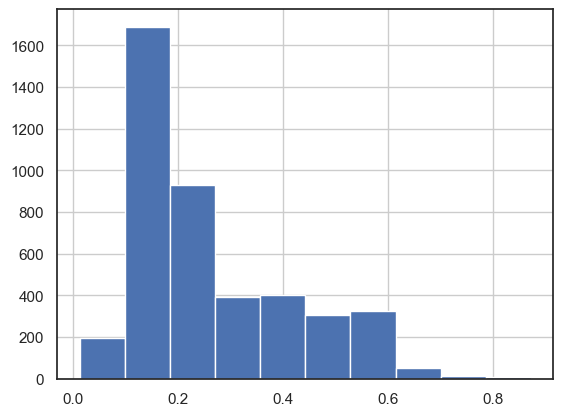

In [105]:
data['relevancy_score'].hist()

In [107]:
(data['relevancy_score']).mean()

np.float64(0.2605923005441716)

# Open Pretrained Transformer (OPT)

In [25]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load the OPT model and tokenizer
model_name = "facebook/opt-2.7b"  # You can adjust the size (e.g., opt-1.3b, opt-6.7b)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Define a summarization prompt
def generate_summary(text, max_length=100):
    prompt = f"Summarize the following text:\n\n{text}\n\nSummary:"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to("cuda")
    
    # Generate the summary
    outputs = model.generate(inputs.input_ids, max_length=max_length, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract the generated summary
    return summary.replace(prompt, "").strip()

# Test with a sample input
test_text = (
    "Artificial intelligence (AI) refers to the simulation of human intelligence in machines "
    "that are programmed to think and learn. These machines are capable of performing tasks "
    "that typically require human intelligence, such as visual perception, speech recognition, "
    "decision-making, and language translation."
)

try:
    summary = generate_summary(test_text, max_length=50)
    print("Generated Summary:", summary)
except Exception as e:
    print("Error generating summary:", e)


Error generating summary: Torch not compiled with CUDA enabled
